In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim, autograd
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)

#!pip install sympy

cuda:0


In [ ]:
# Reference:
# github.com/xdfeng7370/Deep-Ritz-Method

In [27]:
#randomly sample {num_points} points from interior of [-1, 1]^dim
def sample_interior_points(num_points=128, dim=2):
    return torch.rand(num_points, dim) * 2 - 1

#randomly sample {num_points} points from [-1, 1]x[-1, 1] boundary
def sample_boundary_points_2d(num_points = 33):   
    index = torch.rand(num_points, 1)
    index1 = torch.rand(num_points, 1) * 2 - 1
    xb1 = torch.cat((index, torch.zeros_like(index)), dim=1)
    xb2 = torch.cat((index1, torch.ones_like(index1)), dim=1)
    xb3 = torch.cat((index1, torch.full_like(index1, -1)), dim=1)
    xb4 = torch.cat((torch.ones_like(index1), index1), dim=1)
    xb5 = torch.cat((torch.full_like(index1, -1), index1), dim=1)
    x_boundary = torch.cat((xb1, xb2, xb3, xb4, xb5), dim=0)
    return x_boundary

In [38]:
class DeepRitz(nn.Module):
    class ResidualBlock(nn.Module):
        def __init__(self, m, activation):
            super().__init__()
            self.linear1 = nn.Linear(m, m)
            self.linear2 = nn.Linear(m, m)
            self.activation = activation
        def forward(self, x):
            residual = x
            x = self.activation(self.linear1(x))
            x = self.linear2(x)
            return self.activation(x) + residual

    def __init__(self, in_dim, m, out_dim, depth=4, activation=nn.Tanh()):
        super(DeepRitz, self).__init__()
        self.activation = activation
        self.initial_layer = nn.Linear(in_dim, m)
        self.middle_layers = nn.ModuleList([self.ResidualBlock(m, self.activation) for _ in range(depth)])
        self.final_layer = nn.Linear(m, out_dim)
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = self.activation(self.initial_layer(x))
        for block in self.middle_layers:
            x = block(x)
        x = self.final_layer(x)
        return x

In [39]:
in_dim, m, out_dim = 2, 10, 1
depth = 4
activation = nn.Tanh()
model = DeepRitz(in_dim, m, out_dim, depth, activation).to(device)
print(model)

DeepRitz(
  (activation): Tanh()
  (initial_layer): Linear(in_features=2, out_features=10, bias=True)
  (middle_layers): ModuleList(
    (0-3): 4 x ResidualBlock(
      (linear1): Linear(in_features=10, out_features=10, bias=True)
      (linear2): Linear(in_features=10, out_features=10, bias=True)
      (activation): Tanh()
    )
  )
  (final_layer): Linear(in_features=10, out_features=1, bias=True)
)


In [44]:
sample_interior_points(num_points=128, dim=2).shape

torch.Size([128, 2])

In [46]:
from torchsummary import summary
summary(model, input_size=(128, 2), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 128, 10]              30
              Tanh-2              [-1, 128, 10]               0
              Tanh-3              [-1, 128, 10]               0
              Tanh-4              [-1, 128, 10]               0
              Tanh-5              [-1, 128, 10]               0
              Tanh-6              [-1, 128, 10]               0
            Linear-7              [-1, 128, 10]             110
              Tanh-8              [-1, 128, 10]               0
              Tanh-9              [-1, 128, 10]               0
             Tanh-10              [-1, 128, 10]               0
             Tanh-11              [-1, 128, 10]               0
             Tanh-12              [-1, 128, 10]               0
           Linear-13              [-1, 128, 10]             110
             Tanh-14              [-1, 

In [40]:
num_epochs = 50000
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3.5e-4)
best_loss = float('inf')  
loss_history = []

for epoch in range(num_epochs + 1):
    # sample the input data points
    xr = sample_interior_points(num_points=128, dim=2)
    xb = sample_boundary_points_2d(num_points=33)
    xr = xr.to(device)
    xr.requires_grad_()
    xb = xb.to(device)

    # model generates outputs
    output_r = model(xr)
    output_b = model(xb)

    # computes the gradients of "output_r" with respect to "xr"
    grads = autograd.grad(outputs=output_r, inputs=xr,
                          grad_outputs=torch.ones_like(output_r),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]

    # computes the L2 norm of the gradients for each data point
    loss_r = 0.5 * torch.sum(torch.pow(grads, 2), dim=1) - output_r
    loss_r_mean = torch.mean(loss_r)  # average this residual loss over all data points

    # computes the mean squared error of the model's output at the boundary points
    loss_b_mean = torch.mean(torch.pow(output_b, 2))

    # compute the total loss which is a weighted sum of the residual loss
    loss = 4 * loss_r_mean + 9 * 500 * loss_b_mean

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Logging
    loss_history.append(loss.item())
    if epoch % 100 == 0:
        if epoch % 1000 == 0:
            print(f'Epoch: {epoch}, Loss: {loss.item()}')
        # Save the model if it's the best so far
        if torch.abs(loss) < best_loss:
            best_loss = torch.abs(loss).item()
            torch.save(model.state_dict(), 'deep_ritz_best.mdl')

Epoch: 0, Loss: 1959.344970703125
Epoch: 1000, Loss: 0.3189460039138794
Epoch: 2000, Loss: 0.07332122325897217
Epoch: 3000, Loss: 0.033022742718458176
Epoch: 4000, Loss: 0.011664234101772308
Epoch: 5000, Loss: -0.004084525629878044
Epoch: 6000, Loss: -0.012003637850284576
Epoch: 7000, Loss: -0.005443774163722992
Epoch: 8000, Loss: -0.023558270186185837
Epoch: 9000, Loss: -0.04076515883207321
Epoch: 10000, Loss: -0.044307492673397064
Epoch: 11000, Loss: -0.038786888122558594
Epoch: 12000, Loss: -0.03642718493938446
Epoch: 13000, Loss: -0.06708028167486191
Epoch: 14000, Loss: -0.041797444224357605
Epoch: 15000, Loss: -0.06267732381820679
Epoch: 16000, Loss: -0.0815543383359909
Epoch: 17000, Loss: -0.07970079779624939
Epoch: 18000, Loss: -0.05724401772022247
Epoch: 19000, Loss: -0.060463666915893555
Epoch: 20000, Loss: -0.05669765919446945
Epoch: 21000, Loss: -0.07656913250684738
Epoch: 22000, Loss: -0.09920012950897217
Epoch: 23000, Loss: -0.07429613918066025
Epoch: 24000, Loss: -0.09002

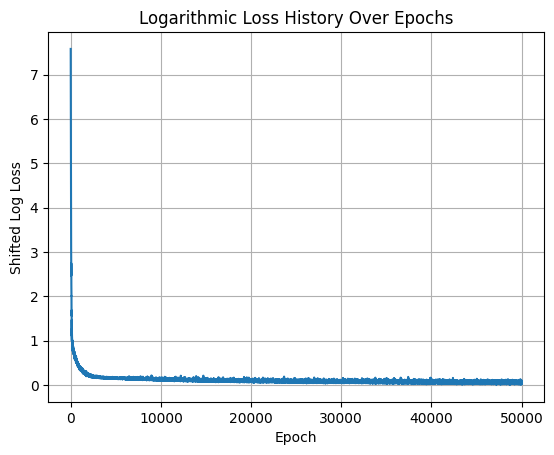

In [41]:
import matplotlib.pyplot as plt
import numpy as np

loss_history_np = np.array(loss_history)
min_loss = np.min(loss_history_np)
shift = np.abs(min_loss) + 1

shifted_log_loss = np.log(loss_history_np + shift)

plt.plot(shifted_log_loss)
plt.xlabel('Epoch')
plt.ylabel('Shifted Log Loss')
plt.title('Logarithmic Loss History Over Epochs')
plt.grid(True)
plt.show()


In [42]:
model.eval()
with torch.no_grad():
    x1 = torch.linspace(-1, 1, 1001)
    x2 = torch.linspace(-1, 1, 1001)
    X, Y = torch.meshgrid(x1, x2)
    Z = torch.cat((Y.flatten()[:, None], Y.T.flatten()[:, None]), dim=1)
    Z = Z.to(device)
    pred = model(Z)

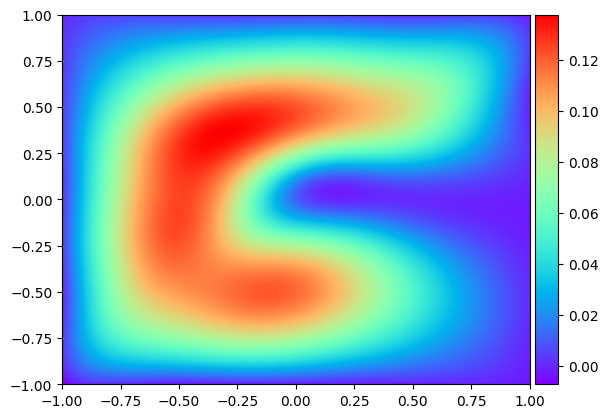

In [43]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure()
pred = pred.cpu().numpy()
pred = pred.reshape(1001, 1001)
ax = plt.subplot(1, 1, 1)
h = plt.imshow(pred, interpolation='nearest', cmap='rainbow',
               extent=[-1, 1, -1, 1],
               origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(h, cax=cax)
plt.show()